# Fast Style Transfer: Training a Feedforward Network for Artistic Style

### Training Insights

1. **Feedforward Network:**
   We use a residual autoencoder network, the same one employed in the original implementation. This network takes a content image as input and produces a stylized image.

2. **Loss Function:**
   The loss function, as defined in the [Gatys et al. paper](https://arxiv.org/pdf/1508.06576.pdf), remains crucial. It comprises both style and content loss.

3. **Normalization Technique:**
   Instead of batch normalization, we opt for instance normalization, following the findings of the paper titled [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/abs/1607.08022). This choice often yields superior results.

4. **Perceptual Loss:**
   VGG19 comes into play for calculating perceptual loss, a critical aspect discussed in the original paper. This loss is instrumental in ensuring that the generated images capture the style essence effectively.


In [ ]:
# Texture Networks + Instance Normalization: Feed-forward Synthesis of Textures and Stylized Images

The **Texture Networks** model, as introduced in the paper *"Texture Networks: Feed-forward Synthesis of Textures and Stylized Images,"* provides a faster approach to texture generation and image stylization. The key innovation involves training a feedforward generator using a loss function proposed by Gatys et al. Once the model is trained, it enables the instantaneous generation of texture samples or stylized images of varying sizes.

The subsequent advancement in this line of research is presented in *"Improved Texture Networks: Maximizing Quality and Diversity in Feed-forward Stylization and Texture Synthesis."* This iteration focuses on enhancing the architectural design of the generator network. Notably, the transition from batch normalization to Instance Normalization is highlighted as a pivotal improvement. This alteration streamlines the learning process, leading to a significant enhancement in output quality.

Furthermore, the model's stylization component draws inspiration from *"Perceptual Losses for Real-Time Style Transfer and Super-Resolution,"* further enriching its capabilities.

For those interested, an online demo showcasing the capabilities of this model is available [here](insert_link_here) (with thanks to RiseML).


### Importing Necessary Modules

Lets start by importing all necessary modules:

- `numpy` : for arrays manipulation
- `tensorflow` : for tensor operations
- `tensorflow.keras` : high level neural network library for tensorflow for creating neural networks
- `pillow` : for converting an image to numpy array and numpy array to image, saving out output image.
- `time` : for calculating time of each iteration
- `matplotlib` : for displaying images and graphs in notebook
- `request`, `base64`, `io` : for downloading and loading image from url
- `os` : operating system level commands

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import load_model,Model
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib
import requests
import base64
import os
from pathlib import Path
from io import BytesIO
matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Define Utility Functions

In [2]:
def load_image(image_path, dim=None, resize=False):
    img= Image.open(image_path)
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

The above function is used to load image from path specified and convert it into numpy array

In [3]:
def load_url_image(url,dim=None,resize=False):
    img_request=requests.get(url)
    img= Image.open(BytesIO(img_request.content))
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

This function loads image from url and convert it into numpy array

In [4]:
def array_to_img(array):
    array=np.array(array,dtype=np.uint8)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

In [5]:
def show_image(image,title=None):
    if len(image.shape)>3:
        image=tf.squeeze(image,axis=0)
    plt.imshow(image)
    if title:
        plt.title=title

In [6]:
def plot_images_grid(images,num_rows=1):
    n=len(images)
    if n > 1:
        num_cols=np.ceil(n/num_rows)
        fig,axes=plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
        axes=axes.flatten()
        fig.set_size_inches((15,15))
        for i,image in enumerate(images):
            axes[i].imshow(image)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(images[0])

Above three functions are used for converting and plotting images:
- `array_to_img`: Converts an array to image
- `show_image`: plot single image
- `plot_images_grid`: plots batches of images in grid

### Steps for Fast Style Transfer

The training model follows an encoder-decoder architecture enriched with residual layers. Input images are processed through the encoder section and then propagated to the decoder part. The output matches the input size and produces the generated image.

The model is trained using a loss function known as perceptual loss. This loss is calculated similarly to Gatys style transfer, leveraging a pretrained model to extract feature maps from style and content layers. The feature maps are then used to compute style loss and content loss.

To train the model, a diverse dataset is required. In this case, we use a dataset of landscape pictures available [here] It's essential to select a style image, such as a painting or sketch, from the internet, whose style the autoencoder will learn.

During the training process, batches of input training images with diverse content are fed into the autoencoder, generating styled images. Simultaneously, these output images are passed through the loss model (VGG19) to extract features from different layers, including content and style layers. These features are then utilized to calculate style loss and content loss. The weighted sum of these losses yields the perceptual loss, driving the training of the network. The image below, sourced from the paper, illustrates this process:

![Perceptual Loss](https://miro.medium.com/max/1574/1*Um82GJ99gauIOh0U-S11hQ.png)

Post-training, the network can be employed to style any image in a single pass without the need for optimization. 

The main highlights of network:
- Residual Layers
- Encoder Decoder Model
- output from decoder is passed to loss model(VGG) to calculate loss
- training needs compute as we are passing these images to two networks on every step

### Define loss 

For calculating style loss and content loss we need a pretrained model, we are using vgg19 the original implementation uses vgg16.

## Image Preprocessing with VGG19

This function is designed for image preprocessing using the VGG19 model.

**VGGNet**, developed by the **Visual Geometry Group (VGG)** at the University of Oxford, emerged as the 1st runner-up in the ImageNet Large Scale Visual Recognition Competition (ILSVRC) 2014 classification task. While it didn't secure the top spot, VGGNet showcased significant advancements over ZFNet (2013 winner) and AlexNet (2012 winner).

Despite not winning in classification, VGGNet outperformed GoogLeNet in the ILSVRC 2014 localization task.

**VGG19** is a model with weights pre-trained on **ImageNet**, a dataset comprising over 15 million labeled high-resolution images across approximately 22,000 categories. ILSVRC utilizes a subset of ImageNet, consisting of around 1000 images per category. In total, there are approximately 1.3 million training images, 50,000 validation images, and 100,000 testing images.

In [7]:
vgg=vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Here we define layers that we will use to calculate loss.

In [8]:
content_layers=['block4_conv2']

style_layers=['block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1']

Lets define a class that creates loss model with some additional methods for accessing feature maps from network. We have also used these functions in previous post, here we just encapsulated them inside a class.

In [9]:
class LossModel:
    def __init__(self,pretrained_model,content_layers,style_layers):
        self.model=pretrained_model
        self.content_layers=content_layers
        self.style_layers=style_layers
        self.loss_model=self.get_model()

    def get_model(self):
        self.model.trainable=False
        layer_names=self.style_layers + self.content_layers
        outputs=[self.model.get_layer(name).output for name in layer_names]
        new_model=Model(inputs=self.model.input,outputs=outputs)
        return new_model
    
    def get_activations(self,inputs):
        inputs=inputs*255.0
        style_length=len(self.style_layers)
        outputs=self.loss_model(vgg19.preprocess_input(inputs))
        style_output,content_output=outputs[:style_length],outputs[style_length:]
        content_dict={name:value for name,value in zip(self.content_layers,content_output)}
        style_dict={name:value for name,value in zip(self.style_layers,style_output)}
        return {'content':content_dict,'style':style_dict}

Now we create our loss model using above class

In [10]:
loss_model = LossModel(vgg, content_layers, style_layers)

Lets define loss function for calculating content and style loss, below methods `content_loss` and `style _loss` calculates content and style loss respectively. With weighted averaging of these losses we derive perceptual loss defined in `preceptual_loss` function. The details of these loss functions are covered in previous post.

## The content Loss
Given a chosen content layer **l**, the content loss is defined as the Mean Squared Error between the feature map **F** of our content image **C** and the feature map **P** of our generated image **Y**.
![Coontent Loss](https://cdn-images-1.medium.com/max/800/1*1YfGhmzBw7EK3e8CRpZbuA.png)

In [11]:
def content_loss(placeholder,content,weight):
    assert placeholder.shape == content.shape
    return weight*tf.reduce_mean(tf.square(placeholder-content))

## Style Loss

To achieve style transfer, the first step involves calculating the **Gram-matrix**, which is a matrix comprising correlated features, for the tensors output by the style layers. The Gram-matrix is essentially a matrix of dot-products for the vectors of the feature activations of a style layer.

If an entry in the Gram-matrix has a value close to zero, it indicates that the two features in the given layer do not activate simultaneously for the style image. Conversely, a large value in the Gram-matrix suggests that the two features activate simultaneously for the style image. The objective is to create a mixed image that replicates this activation pattern of the style image.

Mathematically, if the feature map is represented as a matrix **F**, each entry in the Gram matrix **G** can be defined as follows:
![Gram Matrix](https://cdn-images-1.medium.com/max/800/1*5xx9KmhVb59Mxe_buOwHBA.png)

The loss function for style closely resembles our content loss, with the distinction that we calculate the Mean Squared Error for the Gram matrices instead of the raw tensor outputs from the layers.
![Style loss](https://cdn-images-1.medium.com/max/800/1*PuYveCM2BlgFfjUCr6I_Ng.png)


In [12]:
def gram_matrix(x):
    gram=tf.linalg.einsum('bijc,bijd->bcd', x, x)
    return gram/tf.cast(x.shape[1]*x.shape[2]*x.shape[3],tf.float32)

### Feature Reconstruction Strategy

```markdown
In the feature reconstruction process, the authors used one layer for the content image and five layers for the style image. However, in our implementation, we will use all five layers for both the content and style images. These layers are specifically conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1, corresponding to indices 0, 5, 10, 19, and 28, respectively. This selection targets convolutional layers that follow MaxPool layers, providing us with the necessary feature extraction capabilities.


In [13]:
def style_loss(placeholder,style, weight):
    assert placeholder.shape == style.shape
    s=gram_matrix(style)
    p=gram_matrix(placeholder)
    return weight*tf.reduce_mean(tf.square(s-p))

In [14]:
def preceptual_loss(predicted_activations,content_activations,
                    style_activations,content_weight,style_weight,
                    content_layers_weights,style_layer_weights):
    pred_content = predicted_activations["content"]
    pred_style = predicted_activations["style"]
    c_loss = tf.add_n([content_loss(pred_content[name],content_activations[name],
                                  content_layers_weights[i]) for i,name in enumerate(pred_content.keys())])
    c_loss = c_loss*content_weight
    s_loss = tf.add_n([style_loss(pred_style[name],style_activations[name],
                                style_layer_weights[i]) for i,name in enumerate(pred_style.keys())])
    s_loss = s_loss*style_weight
    return c_loss+s_loss

### Create Autoencoder

Here we first defined all necessary layers for our network:

- `ReflectionPadding2D` : for applying reflection padding to images in conv nets
- `InstanceNormalization` : We are using instance normalization instead of batch normalization as it gives better result. It normalize inputs across channel.
- `ConvLayer` : Block of conv layer with padding-> conv_layer-> instance_normalization combined
- `ResidualLayer` : Residual layer with two ConvLayer block
- `UpsampleLayer` : upsample the bottleneck representation (if you have read about autoencoders you know what I mean) in autoencoder. It can be considered as deconvolutional layers.

### Reflection Padding 2D Layer

The `ReflectionPadding2D` class is a custom layer designed for use in convolutional neural networks (CNNs) within the TensorFlow framework. Its purpose is to implement reflection padding in two dimensions.

**Reflection padding** is a technique often employed in CNNs to handle border effects during convolution operations. Instead of zero-padding, where extra rows and columns are added with zero values, reflection padding copies the values from the input image's edges, mirroring them as if reflected.

#### Explanation:

1. **Initialization:**
   - The constructor (`__init__` method) accepts a parameter `padding`, which defaults to (1, 1). This parameter represents the number of pixels to pad in both the height and width dimensions.
   - The `super().__init__(**kwargs)` call initializes the layer as a subclass of the `tf.keras.layers.Layer`.

2. **Forward Pass:**
   - The `call` method defines the forward pass of the layer. It takes an `input_tensor` as its argument.
   - Inside the `call` method, the `padding_width` and `padding_height` are extracted from the provided padding tuple.
   - `tf.pad` is then used to perform reflection padding on the input tensor. The `[[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0]]` argument specifies the padding configuration. The first and last dimensions (`[0,0]`) indicate no padding in the batch and channel dimensions, respectively. The middle dimensions specify the padding in the height and width dimensions using the reflection padding technique ('REFLECT').

This `ReflectionPadding2D` layer can be seamlessly integrated into a CNN architecture to enhance the handling of border effects, contributing to more accurate feature extraction and preserving spatial information at the edges of the input data.


In [15]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)
    def call(self, input_tensor):
        padding_width, padding_height = self.padding
        return tf.pad(input_tensor, [[0,0], [padding_height, padding_height], 
                                     [padding_width, padding_width], [0,0] ], 'REFLECT')

### Instance Normalization Layer

The `InstanceNormalization` class is a custom layer implemented using TensorFlow's Keras API. It serves the purpose of applying instance normalization to the input tensor. Instance normalization is a normalization technique that independently normalizes each instance (or sample) along its channels.

#### Initialization:

The constructor (`__init__` method) is simple and does not take any specific parameters. It ensures proper initialization by calling the parent class constructor using `super().__init__(**kwargs)`.

#### Forward Pass:

The `call` method defines the forward pass of the layer, taking an `inputs` tensor as its argument. Here's a breakdown of the steps:

1. Extracting Dimensions:
   - The dimensions of the input tensor (`batch`, `rows`, `cols`, and `channels`) are extracted using `inputs.get_shape()`.

2. Calculating Mean and Variance:
   - Using TensorFlow's `tf.nn.moments` function, mean (`mu`) and variance (`var`) are calculated across the spatial dimensions (`[1, 2]`). The `keepdims=True` argument maintains the dimensions.

3. Trainable Variables:
   - Two trainable variables, `shift` and `scale`, are created with shapes `[channels]`. These are initialized with zeros and ones, respectively.

4. Normalization:
   - A small constant `epsilon` (1e-3) is introduced to prevent division by zero.
   - The normalization is computed using the instance normalization formula: `(inputs - mu) / tf.sqrt(var + epsilon)`.

5. Scaling and Shifting:
   - The normalized values are scaled by the learnable parameter `scale` and shifted by `shift`. This introduces flexibility to the normalization process.

#### Summary:

The `InstanceNormalization` layer is a useful tool in neural networks, particularly in scenarios where instance-wise normalization is preferred over batch normalization. It allows the network to adapt and capture the statistics of each instance independently during training.

In [16]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
    def call(self,inputs):
        batch, rows, cols, channels = [i for i in inputs.get_shape()]
        mu, var = tf.nn.moments(inputs, [1,2], keepdims=True)
        shift = tf.Variable(tf.zeros([channels]))
        scale = tf.Variable(tf.ones([channels]))
        epsilon = 1e-3
        normalized = (inputs-mu)/tf.sqrt(var + epsilon)
        return scale * normalized + shift

### ConvLayer

The `ConvLayer` class is a custom convolutional layer implemented in TensorFlow's Keras API. It combines reflection padding, 2D convolution, and instance normalization to create a versatile building block for convolutional neural networks.

#### Initialization:

The constructor (`__init__` method) takes parameters for the number of filters (`filters`), the size of the convolutional kernel (`kernel_size`), and an optional stride (`strides`). Additional keyword arguments can be passed to the parent class constructor.

#### Components:

1. **Reflection Padding:**
   - The `padding` attribute is an instance of the `ReflectionPadding2D` layer, providing reflection padding based on half of the kernel size in each dimension.

2. **Convolution:**
   - The `conv2d` attribute is a 2D convolution layer (`tf.keras.layers.Conv2D`) configured with the specified number of filters, kernel size, and optional strides.

3. **Instance Normalization:**
   - The `bn` attribute is an instance of the `InstanceNormalization` layer, applying instance-wise normalization after the convolution.

#### Forward Pass:

The `call` method defines the forward pass, involving reflection padding, convolution, and instance normalization.

#### Summary:

The `ConvLayer` enhances convolutional neural networks by incorporating reflection padding and instance normalization. It is designed to contribute to both expressiveness and performance.

In [17]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,strides=1,**kwargs):
        super(ConvLayer,self).__init__(**kwargs)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
    def call(self,inputs):
        x=self.padding(inputs)
        x=self.conv2d(x)
        x=self.bn(x)
        return x

### ResidualLayer

The `ResidualLayer` class represents a residual block commonly used in deep neural networks to address the vanishing gradient problem. It is composed of two convolutional layers (`ConvLayer`), a rectified linear unit activation (`ReLU`), and an element-wise addition operation.

#### Initialization:

The constructor (`__init__` method) takes parameters for the number of filters (`filters`) and the size of the convolutional kernel (`kernel_size`). Additional keyword arguments can be passed to the parent class constructor.

#### Components:

1. **Convolutional Layers:**
   - `conv2d_1` and `conv2d_2` are instances of the `ConvLayer` class, responsible for feature extraction.

2. **ReLU Activation:**
   - `relu` is an instance of the `tf.keras.layers.ReLU` layer, introducing non-linearity to the network.

3. **Element-Wise Addition:**
   - `add` is an instance of the `tf.keras.layers.Add` layer, performing an element-wise addition of the output from the second convolutional layer and the original input (residual).

#### Forward Pass:

The `call` method defines the forward pass of the residual layer, involving two convolutions, ReLU activation, and an element-wise addition with the original input.

#### Summary:

The `ResidualLayer` is a fundamental building block in deep neural networks, enabling efficient training of deep architectures by mitigating the vanishing gradient problem.

In [18]:
class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,**kwargs):
        super(ResidualLayer,self).__init__(**kwargs)
        self.conv2d_1=ConvLayer(filters,kernel_size)
        self.conv2d_2=ConvLayer(filters,kernel_size)
        self.relu=tf.keras.layers.ReLU()
        self.add=tf.keras.layers.Add()
    def call(self,inputs):
        residual=inputs
        x=self.conv2d_1(inputs)
        x=self.relu(x)
        x=self.conv2d_2(x)
        x=self.add([x,residual])
        return x

### UpsampleLayer

The `UpsampleLayer` class is a custom layer designed for upsampling in neural networks. It integrates several components to effectively increase the spatial resolution of the input.

#### Initialization:

The constructor (`__init__` method) takes the following parameters:
- `filters`: Number of filters in the convolutional layer.
- `kernel_size`: Size of the convolutional kernel.
- `strides`: (Optional) Stride for the convolution operation, defaulting to 1.
- `upsample`: Upsampling factor, specifying how much to increase the spatial resolution.
- `**kwargs`: Additional keyword arguments for the layer.

#### Components:

1. **Upsampling:**
   - The `upsample` attribute is an instance of `tf.keras.layers.UpSampling2D`, responsible for increasing the spatial resolution of the input tensor.

2. **Reflection Padding:**
   - The `padding` attribute is an instance of `ReflectionPadding2D`, providing reflection padding based on half of the kernel size in each dimension. This helps handle border effects during convolution.

3. **Convolution:**
   - The `conv2d` attribute is a 2D convolution layer (`tf.keras.layers.Conv2D`) configured with the specified number of filters, kernel size, and optional strides. It extracts features from the upsampled and padded tensor.

4. **Instance Normalization:**
   - The `bn` attribute is an instance of `InstanceNormalization`, applying instance-wise normalization after the convolution to improve the stability and convergence of the network.

#### Forward Pass:

The `call` method defines the forward pass of the upsampling layer:
1. **Upsampling:**
   - The input tensor is upsampled using the specified factor.

2. **Reflection Padding:**
   - The upsampled tensor undergoes reflection padding to handle border effects.

3. **Convolution:**
   - Convolution is applied to the padded tensor, extracting features relevant to the increased spatial resolution.

4. **Instance Normalization:**
   - Instance normalization is performed, enhancing the stability and generalization of the features.

#### Summary:

The `UpsampleLayer` is a comprehensive solution for increasing spatial resolution in neural networks. It employs upsampling, reflection padding, convolution, and instance normalization to enhance the quality of high-resolution features.

In [19]:
class UpsampleLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,strides=1,upsample=2,**kwargs):
        super(UpsampleLayer,self).__init__(**kwargs)
        self.upsample=tf.keras.layers.UpSampling2D(size=upsample)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
    def call(self,inputs):
        x=self.upsample(inputs)
        x=self.padding(x)
        x=self.conv2d(x)
        return self.bn(x)

Using these layers defined above lets create an convolutional autoencoder.

Architecture:

- 3 ConvLayer
- 5 ResidualLayer
- 3 UpsampleLayer

In [20]:
class StyleTransferModel(tf.keras.Model):
    def __init__(self,**kwargs):
        super(StyleTransferModel, self).__init__(name='StyleTransferModel',**kwargs)
        self.conv2d_1= ConvLayer(filters=32,kernel_size=(9,9),strides=1,name="conv2d_1_32")
        self.conv2d_2= ConvLayer(filters=64,kernel_size=(3,3),strides=2,name="conv2d_2_64")
        self.conv2d_3= ConvLayer(filters=128,kernel_size=(3,3),strides=2,name="conv2d_3_128")
        self.res_1=ResidualLayer(filters=128,kernel_size=(3,3),name="res_1_128")
        self.res_2=ResidualLayer(filters=128,kernel_size=(3,3),name="res_2_128")
        self.res_3=ResidualLayer(filters=128,kernel_size=(3,3),name="res_3_128")
        self.res_4=ResidualLayer(filters=128,kernel_size=(3,3),name="res_4_128")
        self.res_5=ResidualLayer(filters=128,kernel_size=(3,3),name="res_5_128")
        self.deconv2d_1= UpsampleLayer(filters=64,kernel_size=(3,3),name="deconv2d_1_64")
        self.deconv2d_2= UpsampleLayer(filters=32,kernel_size=(3,3),name="deconv2d_2_32")
        self.deconv2d_3= ConvLayer(filters=3,kernel_size=(9,9),strides=1,name="deconv2d_3_3")
        self.relu=tf.keras.layers.ReLU()
    def call(self, inputs):
        x=self.conv2d_1(inputs)
        x=self.relu(x)
        x=self.conv2d_2(x)
        x=self.relu(x)
        x=self.conv2d_3(x)
        x=self.relu(x)
        x=self.res_1(x)
        x=self.res_2(x)
        x=self.res_3(x)
        x=self.res_4(x)
        x=self.res_5(x)
        x=self.deconv2d_1(x)
        x=self.relu(x)
        x=self.deconv2d_2(x)
        x=self.relu(x)
        x=self.deconv2d_3(x)
        x = (tf.nn.tanh(x) + 1) * (255.0 / 2)
        return x
    
    ## used to print shapes of each layer to check if input shape == output shape
    ## I don't know any better solution to this right now
    def print_shape(self,inputs):
        print(inputs.shape)
        x=self.conv2d_1(inputs)
        print(x.shape)
        x=self.relu(x)
        x=self.conv2d_2(x)
        print(x.shape)
        x=self.relu(x)
        x=self.conv2d_3(x)
        print(x.shape)
        x=self.relu(x)
        x=self.res_1(x)
        print(x.shape)
        x=self.res_2(x)
        print(x.shape)
        x=self.res_3(x)
        print(x.shape)
        x=self.res_4(x)
        print(x.shape)
        x=self.res_5(x)
        print(x.shape)
        x=self.deconv2d_1(x)
        print(x.shape)
        x=self.relu(x)
        x=self.deconv2d_2(x)
        print(x.shape)
        x=self.relu(x)
        x=self.deconv2d_3(x)
        print(x.shape)

define input shape and batch_size here

In [21]:
input_shape=(256,256,3)
batch_size=4

Create style model using `StyleTransferModel` class

In [22]:
style_model = StyleTransferModel()

Here we check shape of all layers and verify input shape and output shape

In [23]:
style_model.print_shape(tf.zeros(shape=(1,*input_shape)))

(1, 256, 256, 3)
(1, 256, 256, 32)
(1, 128, 128, 64)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 128, 128, 64)
(1, 256, 256, 32)
(1, 256, 256, 3)


### Training model

Here we have defined an optimizer for training, we are using Adam optimizer with learning rate 1e-3

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [25]:
def train_step(dataset,style_activations,steps_per_epoch,style_model,loss_model,optimizer,
               checkpoint_path="./",content_weight=1e4, style_weight=1e-2,
               total_variation_weight=0.004,content_layers_weights=[1],style_layers_weights=[1] * 5):
    batch_losses=[]
    steps=1
    save_path=os.path.join(checkpoint_path,f"model_checkpoint.ckpt")
    print("Model Checkpoint Path: ",save_path)
    for input_image_batch in dataset:
        if steps-1 >= steps_per_epoch:
            break
        with tf.GradientTape() as tape:
            outputs=style_model(input_image_batch)
            outputs=tf.clip_by_value(outputs, 0, 255)
            pred_activations=loss_model.get_activations(outputs/255.0)
            content_activations=loss_model.get_activations(input_image_batch)["content"] 
            curr_loss=preceptual_loss(pred_activations,content_activations,style_activations,content_weight,
                                      style_weight,content_layers_weights,style_layers_weights)
            curr_loss += total_variation_weight*tf.image.total_variation(outputs)
        batch_losses.append(curr_loss)
        grad = tape.gradient(curr_loss,style_model.trainable_variables)
        optimizer.apply_gradients(zip(grad,style_model.trainable_variables))
        if steps % 1000==0:
            print("checkpoint saved ",end=" ")
            style_model.save_weights(save_path)
            print(f"Loss: {tf.reduce_mean(batch_losses).numpy()}")
        steps+=1
    return tf.reduce_mean(batch_losses)

In above function we have defined single training step. Inside the function:

- first we defined save_path for model checkpointing
- for number of steps_per_epoch we run a training loop
- for every step we forward pass batch of image pass it to our loss model 
- get content_layer activations for the batch of images
- together with style activations from style image and content activations we calculate perceptual loss
- we add some total variation loss to image for smoothening
- calculate gradients of loss function with respect to model trainable parameters
- finally backpropogates to optimize
- at every 1000 steps saving checkpoints

### Configure Dataset for training

In [26]:
from pathlib import Path
from sklearn.model_selection import train_test_split

In [27]:
class TensorflowDatasetLoader:
    def __init__(self, dataset_path, batch_size=4, image_size=(256, 256), num_images=None, test_size=0.2, random_state=42):
        images_paths = [str(path) for path in Path(dataset_path).glob("*.jpg")]
        self.length = len(images_paths)
        if num_images is not None:
            images_paths = images_paths[0:num_images]

        # Split the dataset into training and testing sets
        train_paths, test_paths = train_test_split(images_paths, test_size=test_size, random_state=random_state)

        # Create TensorFlow datasets for training and testing
        self.train_dataset = self.create_dataset(train_paths, batch_size, image_size)
        self.test_dataset = self.create_dataset(test_paths, batch_size, image_size)

    def __len__(self):
        return self.length

    def create_dataset(self, paths, batch_size, image_size):
        dataset = tf.data.Dataset.from_tensor_slices(paths).map(
            lambda path: self.load_tf_image(path, dim=image_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset

    def load_tf_image(self, image_path, dim):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, dim)
        image = image / 255.0
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

In [28]:
dataset_path = "/kaggle/input/landscape-pictures"
batch_size = 4
image_size = (256, 256)
num_images = None  # Set to a specific number if you want to limit the number of images
test_size = 0.2
random_state = 42

loader = TensorflowDatasetLoader(dataset_path, batch_size, image_size, num_images, test_size, random_state)

# Display the element spec of the training dataset
print("Training dataset element spec:", loader.train_dataset.element_spec)

# Display the element spec of the testing dataset
print("Testing dataset element spec:", loader.test_dataset.element_spec)

Training dataset element spec: TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None)
Testing dataset element spec: TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None)


Training dataset:


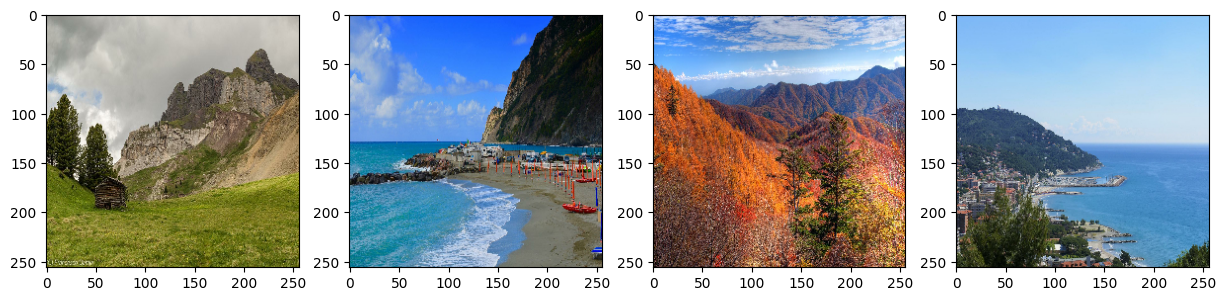

In [29]:
# Plot some images from the training dataset
print("Training dataset:")
plot_images_grid(next(iter(loader.train_dataset.take(1))))

Testing dataset:


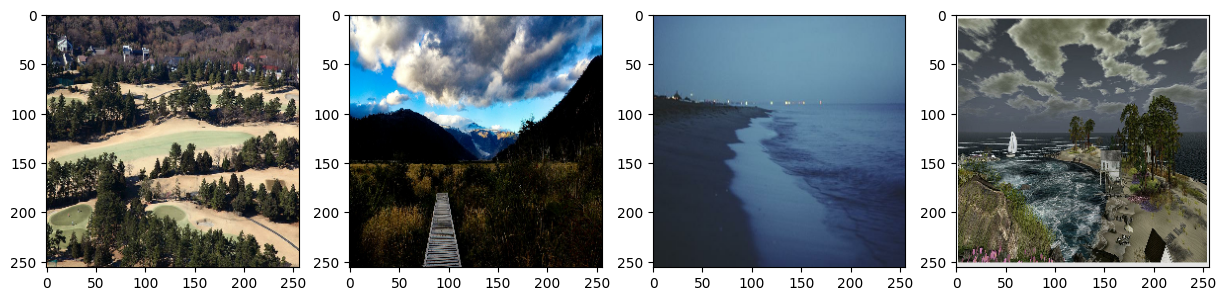

In [30]:
# Plot some images from the testing dataset
print("Testing dataset:")
plot_images_grid(next(iter(loader.test_dataset.take(1))))

Now lets load style image from url using `load_url_image` and plot it.

In [31]:
# setting up style image
url="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
style_image=load_url_image(url,dim=(input_shape[0],input_shape[1]),resize=True)
style_image=style_image/255.0

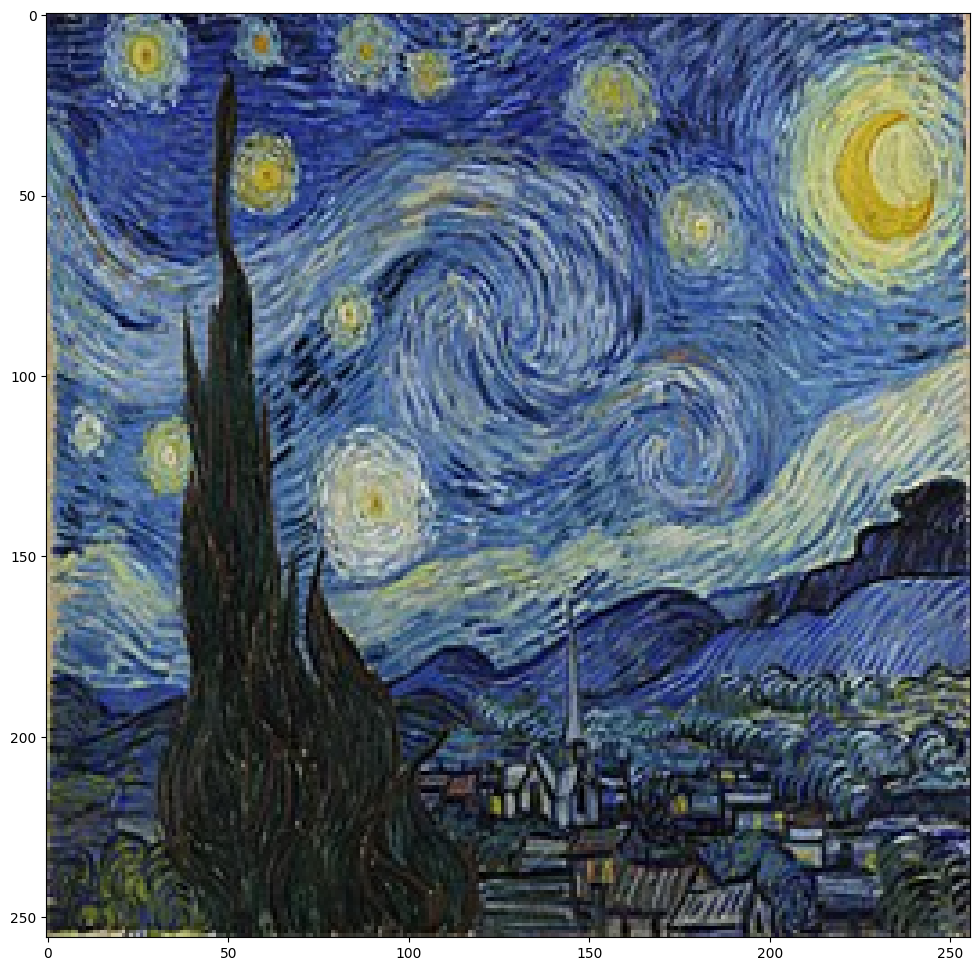

In [32]:
show_image(style_image)

Next we extract style layers feature maps of style image using loss model

In [33]:
style_image=style_image.astype(np.float32)
style_image_batch=np.repeat([style_image],batch_size,axis=0)
style_activations=loss_model.get_activations(style_image_batch)["style"]

### Training model

define content weight, style weight and total variation weight these are hyperparmeters which we can tune to change strength of style and content in output image

In [34]:
content_weight=1e1
style_weight=1e2
total_variation_weight=0.004

Now define number of epochs to train, steps per epochs and model checkpoint path

In [55]:
epochs=12

In [56]:
num_images=len(loader)
steps_per_epochs=num_images//batch_size
print(steps_per_epochs)

1079


In [57]:
model_save_path="/kaggle/working/"
top_folder_name="scream"
save_path=os.path.join(model_save_path,top_folder_name)
print(save_path)

/kaggle/working/scream


In [58]:
os.makedirs(os.path.join(model_save_path,top_folder_name),exist_ok=True)

Enable mixed precision training it offers significant computational speedup by performing operations in half-precision format.

In [59]:
try:
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy) 
except:
    pass

if previous checkpoint exist at that path load that checkpoint and continue further training else we train from scratch

In [60]:
if os.path.isfile(os.path.join(save_path,"model_checkpoint.ckpt.index")):
    style_model.load_weights(os.path.join(save_path,"model_checkpoint.ckpt"))
    print("resuming training ...")
else:
    print("training scratch ...")

resuming training ...


Finally we start training model. At each epoch we are calling `train_step` function which runs till number of steps er epochs defined and after every epoch save model checkpoint for further inferencing and training

In [61]:
epoch_losses=[]
for epoch in range(1,epochs+1):
    print(f"epoch: {epoch}")
    batch_loss=train_step(loader.train_dataset,style_activations,steps_per_epochs,style_model,loss_model,optimizer,
                          save_path,
                          content_weight,style_weight,total_variation_weight)
    style_model.save_weights(os.path.join(save_path,"model_checkpoint.ckpt"))
    print("Model Checkpointed at: ",os.path.join(save_path,"model_checkpoint.ckpt"))
    print(f"loss: {batch_loss.numpy()}")
    epoch_losses.append(batch_loss)

epoch: 1
Model Checkpoint Path:  /kaggle/working/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 7733896.0
Model Checkpointed at:  /kaggle/working/scream/model_checkpoint.ckpt
loss: 7718962.5
epoch: 2
Model Checkpoint Path:  /kaggle/working/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 7488921.5
Model Checkpointed at:  /kaggle/working/scream/model_checkpoint.ckpt
loss: 7473662.5
epoch: 3
Model Checkpoint Path:  /kaggle/working/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 7265385.5
Model Checkpointed at:  /kaggle/working/scream/model_checkpoint.ckpt
loss: 7254456.5
epoch: 4
Model Checkpoint Path:  /kaggle/working/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 7180610.5
Model Checkpointed at:  /kaggle/working/scream/model_checkpoint.ckpt
loss: 7171571.5
epoch: 5
Model Checkpoint Path:  /kaggle/working/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 6987656.0
Model Checkpointed at:  /kaggle/working/scream/model_checkpoint.ckpt
loss: 6970292.5
epoch: 6
Model 

After training model lets plot loss with respect to epochs and check loss summary

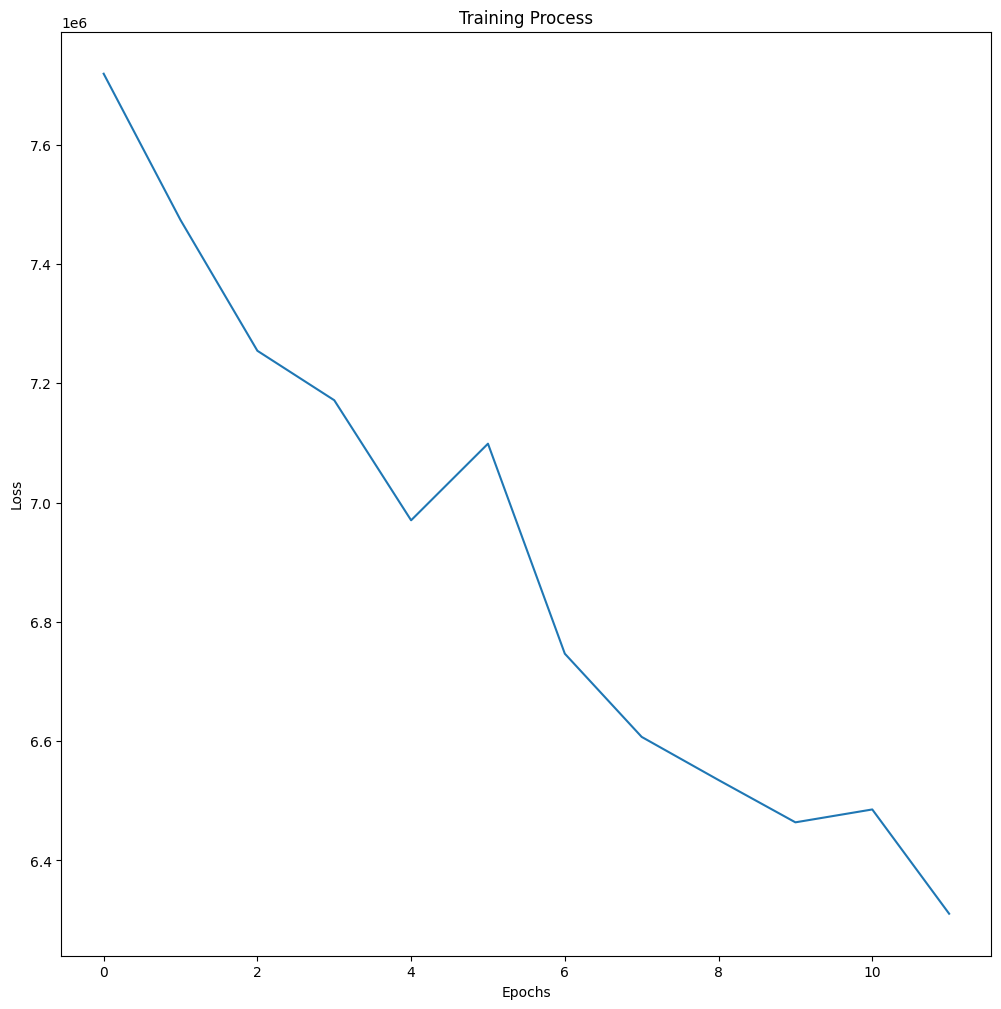

In [62]:
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Process")
plt.show()

Now its time to generate some style images. We start first by loading saved model checkpoint into autoencoder.

In [63]:
if os.path.isfile(os.path.join(save_path,"model_checkpoint.ckpt.index")):
    style_model.load_weights(os.path.join(save_path,"model_checkpoint.ckpt"))
    print("loading weights ...")
else:
    print("no weights found ...")

loading weights ...


In [64]:
# Function to test multiple images
def test_images(image_urls, style_model, dim=(640, 480)):
    for url in image_urls:
        # Load and preprocess the test image
        test_image = Image.open(url)
        test_image=np.expand_dims(test_image,axis=0)
        test_image=test_image.astype(np.float32)

        # Apply the style model
        predicted_image = style_model(test_image)
    
        # Convert test image and predicted image to uint8 for visualization
        test_output = test_image.astype(np.uint8)
        predicted_image=np.clip(predicted_image,0,255)
        predicted_image = predicted_image.astype(np.uint8)
        test_output=tf.squeeze(test_output).numpy()
        predicted_output=tf.squeeze(predicted_image).numpy()

        # Plot the original and styled images
        plot_images_grid([test_output, predicted_output])

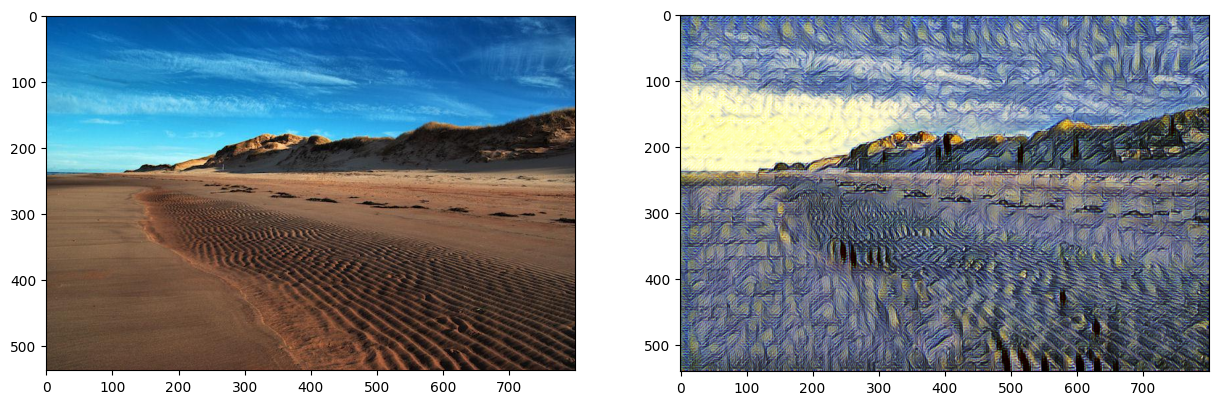

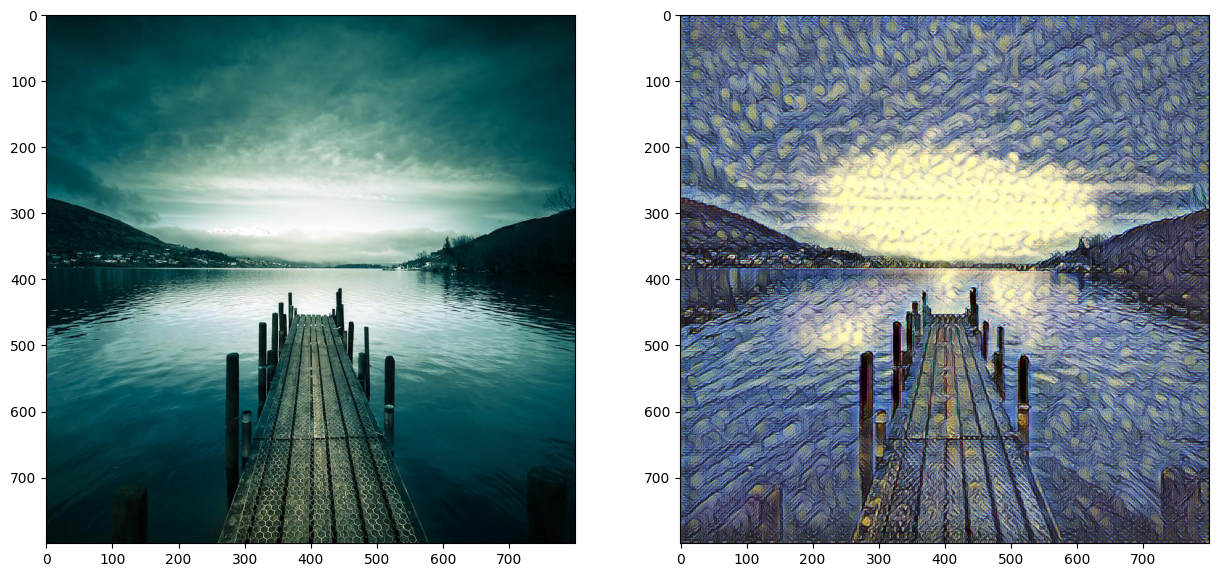

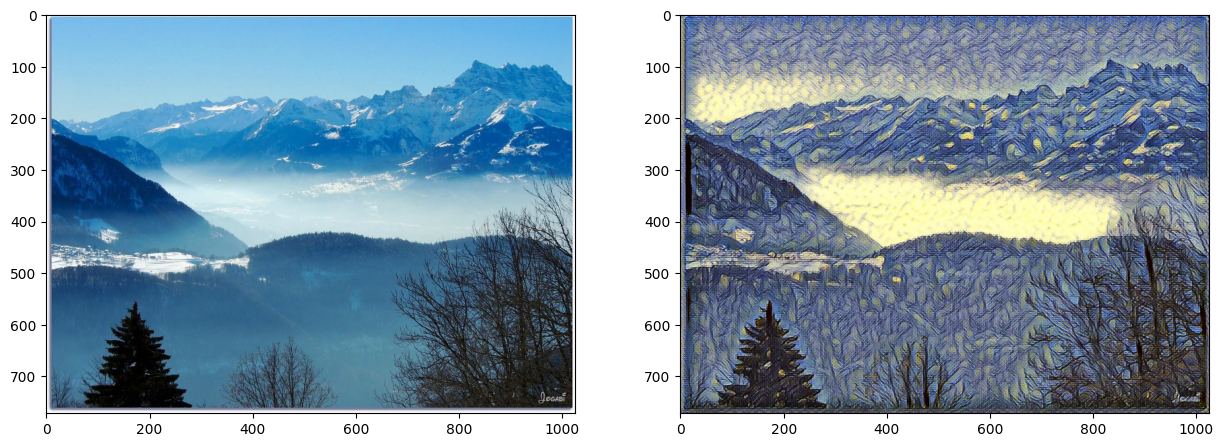

In [65]:
test_image_urls=["/kaggle/input/landscape-pictures/00000002_(4).jpg","/kaggle/input/landscape-pictures/00000000_(2).jpg","/kaggle/input/landscape-pictures/00000000_(3).jpg"]
test_images(test_image_urls,style_model)